### Анализ времени выполнения программы

Исследование проводится с помощью встроенной в систему утилиты <i>time</i>. Каждый эксперимент содержит последовательный запуск программы с одинаковыми аргументами (количество запусков зависит от выбранного объёма выборки). Далее рассчитывается <b>среднее значение</b> времени и сохраняется <b>минимальное</b> и <b>максимальное</b> значения.

На основании результатов каждого проведённого эксперимента создаётся визуализация статистики, позволяющая наглядно определить, как и насколько оптимизация программы повлияла на время её работы.

In [9]:
import pandas as pd
import numpy as np
import datetime
import os
from matplotlib import pylab as plt
from scipy import interpolate
%matplotlib inline

#### Константные данные об анализируемой программе:

In [10]:
PATH = "/home/zkerriga/proj/time_analysis/test/"
PROGRAM = "miniRT"
ARGUMENTS = [PATH + "test_time.rt", "--save"]
TMP_FILE = "tmp.txt"

#### Класс, проводящий эксперимент над программой
Инициализируется:
- строкой для <i>bash</i>
- строкой хэша последнего коммита
- размером выборки (по умолчанию = 10)

In [11]:
class Experiment:
    
    def __init__(self, bash_str:str, last_hash:str, sample_size=10):
        self.bash_command = bash_str
        self.sample_size = sample_size
        self.seconds_array = np.zeros(sample_size, np.float32)
        self.hash = last_hash
        self.mean = 0
        self.max_time = 0
        self.min_time = 0
        
    def get_seconds_from_time_output(self, time_output:str):
        return float(time_output.split()[1][2:-1])
    
    def one_try(self):
        os.system(self.bash_command)
        with open(TMP_FILE, 'r') as file:
            time_output:str = file.read()
            seconds:float = self.get_seconds_from_time_output(time_output)
            print(f"Current program time: {seconds} seconds")
        return seconds
    
    def go(self):
        print("The experiment was started:")
        for i in range(self.sample_size):
            self.seconds_array[i] = self.one_try()
        print("The experiment is over!")
        self.mean = self.seconds_array.mean()
        self.max_time = self.seconds_array.max()
        self.min_time = self.seconds_array.min()
            
    def show_spread_chart(self):
        x = np.arange(self.sample_size)
        f = interpolate.interp1d(x, self.seconds_array, kind='linear')
        xtn = np.arange(0, self.sample_size - 0.9, 0.1)
        ytn = f(xtn)
        plt.axis([-self.sample_size / 20, self.sample_size - (1 - self.sample_size / 20), 0, self.max_time + 1])
        plt.grid()
        plt.title('Демонстрация разброса\nвремени выполнения программы')
        plt.ylabel('Время (в секундах)')
        plt.xlabel('Номер теста')
        plt.plot(x, self.seconds_array, 'o', xtn, ytn, '-')
        plt.show()
        
    def get_result_info(self):
        return f"[EXSPERIMENT]\n\
|\n| hash = {str(self.hash)}\n\
| mean = {str(round(self.mean, 4))}\n\
| maxt = {round(self.max_time, 4)}\n\
| mint = {round(self.min_time, 4)}\n\
|\n\
[END OF EXPERIMENT]"

#### Создание bash строк для эксперимента
- Используется встроенный в систему модуль <i>time</i> для анализа времени
- Используется <i>git</i> для определение хэша последнего коммита 

In [12]:
def get_time_str(path:str, name:str, args:list, tmp:str):
    return f"{{ time {path}{name} {' '.join(args)} ; }} 2>{tmp}"

In [13]:
def get_last_hash(path:str, tmp:str):
    os.system(f"git -C {path} log -n 1 > {tmp}")
    hash_str:str = ""
    with open(tmp, 'r') as file:
        hash_str = file.readline().split()[1][:8]
    return hash_str

In [76]:
# Генерируем bash строку для конкретной программы
bash_time_str = get_time_str(PATH, PROGRAM, ARGUMENTS, TMP_FILE)
print("$>", bash_time_str)

$> { time /home/zkerriga/proj/time_analysis/test/miniRT /home/zkerriga/proj/time_analysis/test/test_time.rt --save ; } 2>time_tmp.txt


#### Старт эксперимента

In [77]:
# Получаем хэш изменений в проекте
last_hash = get_last_hash(PATH, TMP_FILE)
print("Last hash:", last_hash)

Last hash: 655f9cc3


In [78]:
# Создание объекта
experiment = Experiment(bash_time_str, last_hash, sample_size=10)

In [67]:
# Запуск тестирования
experiment.go()

Current program time: 2.14 seconds
Current program time: 2.448 seconds
Current program time: 2.136 seconds
Current program time: 2.495 seconds
Current program time: 1.92 seconds
Current program time: 2.333 seconds
Current program time: 2.37 seconds
Current program time: 2.238 seconds
Current program time: 2.477 seconds
Current program time: 2.156 seconds



In [68]:
# Получаем сводку по эксперименту
print(experiment.get_result_info())

[EXSPERIMENT]
|
| hash = 655f9cc3
| mean = 2.2713
| maxt = 2.494999885559082
| mint = 1.9199999570846558
|
[END OF EXPERIMENT]


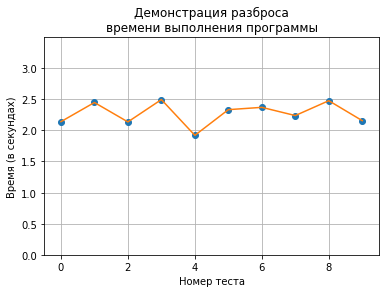

In [69]:
# График
experiment.show_spread_chart()

#### Работа с базой данных и регистрация результатов

In [70]:
# создание DataFrame с помощью чтения данных из файла
dataframe = pd.read_csv('dataset.tsv', header=0, sep='\t')

In [71]:
def add_experiment_to_data(dataframe, experiment):
    if dataframe[dataframe.Hash == experiment.hash].empty:
        new_frame_line = {
                        'Hash': experiment.hash,
                        'Mean_time': round(experiment.mean, 4),
                        'Min_time': round(experiment.min_time, 4),
                        'Max_time': round(experiment.max_time, 4)
        }
        return dataframe.append(new_frame_line, ignore_index=True)
    else:
        return dataframe

In [72]:
# Добавляем результат эксперимента, если хэш новый
dataframe = add_experiment_to_data(dataframe, experiment)

In [73]:
# запись DataFrame в файл
dataframe.to_csv('dataset.tsv', sep='\t', header=True, index=False)

In [80]:
def get_linear_interpolate_arrays(np_array, size:int):
    x = np.arange(size)
    f = interpolate.interp1d(x, np_array, kind='linear')
    xtn = np.arange(0, size - 0.9, 0.1)
    ytn = f(xtn)
    return (xtn, ytn)

def show_statistics(dataframe):
    dataframe_size = dataframe.shape[0]
    if dataframe_size > 1:
        x = np.arange(dataframe_size)
        mean_array = np.array(dataframe.Mean_time, np.float32)
        max_array = np.array(dataframe.Max_time, np.float32)
        min_array = np.array(dataframe.Min_time, np.float32)
        mean_xtn, mean_ytn = get_linear_interpolate_arrays(mean_array, dataframe_size)
        max_xtn, max_ytn = get_linear_interpolate_arrays(max_array, dataframe_size)
        min_xtn, min_ytn = get_linear_interpolate_arrays(min_array, dataframe_size)
        plt.grid()
        plt.title('Зависимость среднего времени\nвыполнения программы от коммита')
        plt.ylabel('Время (в секундах)')
        plt.xlabel('Порядковый номер коммита')
        plt.plot(x, mean_array, 'o')
        plt.plot(max_xtn, max_ytn, 'r--', label='maximum time')
        plt.plot(mean_xtn, mean_ytn, 'y-', label='mean time')
        plt.plot(min_xtn, min_ytn, 'g--', label='minimal time')
        plt.legend()
        plt.show()
    else:
        print("Not enough data!")

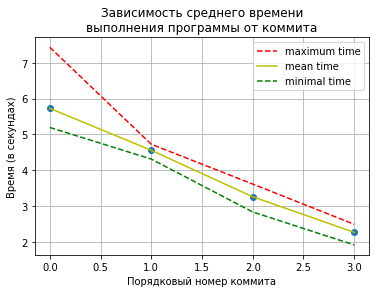

In [81]:
# Формируем общую статистику по результатам экспериментов
show_statistics(dataframe)